<a href="https://colab.research.google.com/github/Hedredo/dagshub_p7/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Work in Progress**

**MLFlow**
- Ajouter une description aux runs mlflow
- Résoudre les dernières erreurs sur un run mlflow
- Ajouter en artifact la matrice de confusion et tester la fonction `plot_confusion_matrix` de `sklearn`
- Ajouter en artifact la courbe ROC et tester la fonction `plot_roc_curve` de `sklearn`
- Simplifier les appels aux différents paramètres et variables pour automatiser simplement le process
- Créer un pipeline pour le tfidf
- Créer une grille d'hyperparamètres pour le tfidf
- Créer une grille d'hyperparamètres pour le modèle
- Créer une fonction pour tester les différents modèles
- Créer une liste des architectures preprocessing + modèle + hyperparamètres
- Utiliser mflow.log_dict pour les hyperparamètres du preprocessing
- Finaliser la fonction de preprocessing avec des True/False pour les différentes étapes en match_case


**Modèle RN inspiré de KERAS**
- Créer un modèle de réseaux de neurones inspiré de KERAS

# **Configuration de l'environnement**

In [7]:
import dagshub
import mlflow
import warnings
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from spacymoji import Emoji
from nltk.tokenize import TweetTokenizer
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import partial


In [8]:
# Check if GPU and CUDA are available
gpu = tf.config.list_physical_devices("GPU")
cuda = torch.cuda.is_available()
print("Tensorflow framework: GPU is", "available" if gpu else "NOT AVAILABLE")
print("Pytorch framework: CUDA is", "available" if cuda else "NOT AVAILABLE")

Tensorflow framework: GPU is available
Pytorch framework: CUDA is NOT AVAILABLE


In [9]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize dagshub repo
try:
    dagshub.init(repo_owner="hedredo", repo_name="dagshub_p7", mlflow=True)
    mlflow.set_experiment("p7")
except Exception as e:
    print("Dagshub repo can't be initialized:", e)

# Initialiser tqdm pour pandas
tqdm.pandas()

# Set a random seed
SEED = 314
np.random.seed(SEED)
print("Random seed set to", SEED)

Initialized MLflow to track repo "hedredo/dagshub_p7"

Repository hedredo/dagshub_p7 initialized!

Random seed set to 314


# **Chargement des données**

In [10]:
# Path to the csv file
path = "./data/raw/training.1600000.processed.noemoticon.csv"

In [11]:
# Read the file
df = pd.read_csv(
    path,
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"],
    usecols=["target", "ids", "date", "user", "text"],  # remove flag column
    parse_dates=["date"],
    encoding="utf-8",
    encoding_errors="replace",  # replace the errors with unicode symbol � (U+FFFD)
).sort_values(by="date", ascending=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 799999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB


# **Analyse pré-exploratoire et préparation des données**

In [13]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the desired columns
for col in ["ids", "user"]:
    df[col] = encoder.fit_transform(df[col])

# Replace 4 with 1 in the target column
df["target"] = df["target"].replace(4, 1)

# Finally, create new columns for month, day, and hour and drop date
df = df.assign(
    **{
        "month": lambda x: x.date.progress_apply(lambda x: x.month),
        "day": lambda x: x.date.progress_apply(lambda x: x.day),
        "hour": lambda x: x.date.progress_apply(lambda x: x.hour),
    }
).drop(columns=["date"])

100%|██████████| 1600000/1600000 [00:02<00:00, 706542.07it/s] 


In [14]:
# Convert the datatypes to save memory
df = df.astype(
    {
        "target": "int8",
        "ids": "int32",
        "user": "int32",
        "month": "int8",
        "day": "int8",
        "hour": "int8",
    }
)

In [15]:
df.head()

,target,ids,user,text,month,day,hour
0,0,0,242711,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,6,22
1,0,1,577449,is upset that he can't update his Facebook by ...,4,6,22
2,0,2,490699,@Kenichan I dived many times for the ball. Man...,4,6,22
3,0,3,65794,my whole body feels itchy and like its on fire,4,6,22
4,0,4,113308,"@nationwideclass no, it's not behaving at all....",4,6,22


In [16]:
print(df.duplicated().sum(), "duplicata trouvé.")
print(
    df.duplicated(subset=["ids", "target", "text"]).sum(),
    "duplicata trouvé sur les colonnes ids, target et text.",
)

0 duplicata trouvé.
0 duplicata trouvé sur les colonnes ids, target et text.


In [17]:
print("Nombre de tweets uniques: ", df["ids"].nunique())
print(
    "Nombre de tweets annotés à la fois positivement et négativement: ",
    df["ids"].size - df["ids"].nunique(),
)

Nombre de tweets uniques:  1598315
Nombre de tweets annotés à la fois positivement et négativement:  1685


On doit retirer ces tweets qui ont deux valeurs car cela va complexifier la capacité du modèle a bien séparé les classes s'ils sont ambiguës.<br>
Regardons un exemple de tweet avec deux valeurs:

In [18]:
# Display 4 examples of duplicated rows with both positive and negative target
with pd.option_context("display.max_colwidth", 150):
    display(df.loc[df["ids"].duplicated(keep=False), ["text", "target"]].head(4))

,text,target
800261,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,1
213,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,0
800300,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",1
275,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",0


In [19]:
# Drop duplicates ids with both positive and negative target
df = df.drop_duplicates(subset=["ids"], keep=False)
print(
    "Nouvelle taille du jeu de données après suppression des duplicata sur ids: ",
    len(df),
)

Nouvelle taille du jeu de données après suppression des duplicata sur ids:  1596630


# **Exploration des données**

In [20]:
# Display the summary statistics of numerical columns
with pd.option_context(
    "display.max_colwidth", 100, "display.float_format", "{:.2f}".format
):
    display(df.describe())

,target,ids,user,month,day,hour
count,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00
mean,0.50,799301.29,330323.25,5.51,14.81,10.96
std,0.50,461450.15,191341.79,0.61,9.79,7.22
min,0.00,0.00,0.00,4.00,1.00,0.00
25%,0.00,399669.25,164668.00,5.00,6.00,5.00
50%,0.50,799342.50,329997.00,6.00,16.00,10.00
75%,1.00,1199004.75,496888.75,6.00,21.00,18.00
max,1.00,1598314.00,659774.00,6.00,31.00,23.00


In [21]:
# Statistics of the number of tweets per user
df["user"].value_counts().describe()

count    659502.000000
mean          2.420963
std           4.697115
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

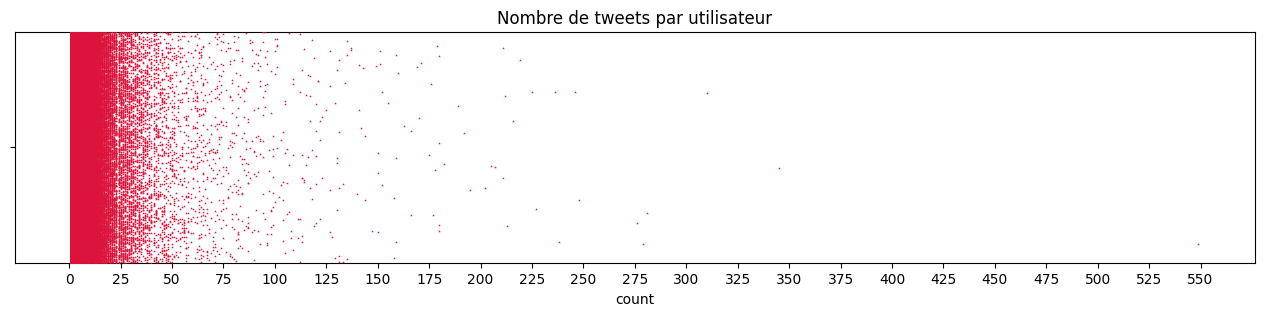

In [22]:
# Show a stripplot of the number of tweets per user
fig, ax = plt.subplots(figsize=(16, 3))
sns.stripplot(
    x=df["user"].value_counts(), jitter=0.5, size=2, marker="*", color="crimson", ax=ax
)
ax.set_title("Nombre de tweets par utilisateur")
ax.set_xticks(range(0, 575, 25))
plt.show()

Un nombre très limité d'utilisateurs tweet énormément alors que la moyenne sur le jeu de données est de 2,4 tweets par utilisateur.<br>
Il n'est pas possible de prendre en compte cette variable dans le modèle car elle peut introduire un biais par ces utilisateurs qui tweentent beaucoup.<br>

In [23]:
# Creation of a palette with 2 colors, crimson and deepskyblue
palette = sns.color_palette(["crimson", "deepskyblue"])

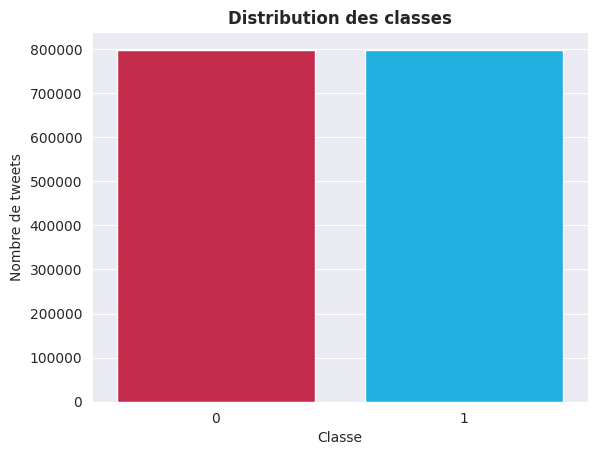

In [24]:
with sns.axes_style("darkgrid"):
    sns.countplot(df, x="target", palette=palette)
    plt.title("Distribution des classes", fontweight="bold")
    plt.xlabel("Classe")
    plt.ylabel("Nombre de tweets")
    plt.show()

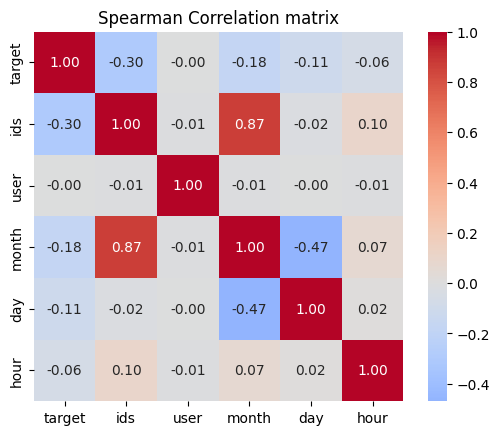

In [25]:
sns.heatmap(
    df.select_dtypes(exclude=["object"]).corr("spearman"),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
)
plt.title("Spearman Correlation matrix")
plt.show()

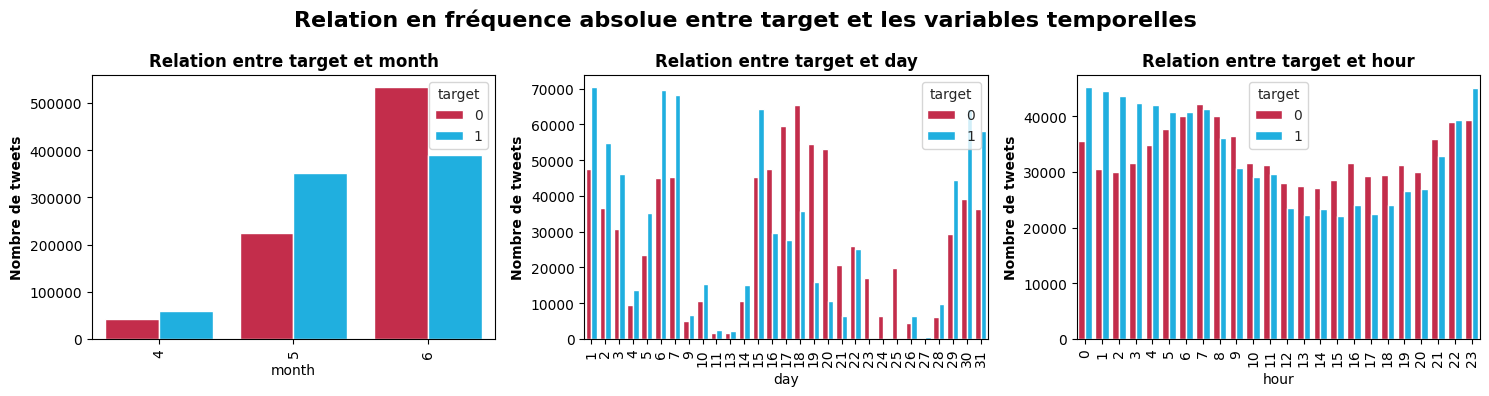

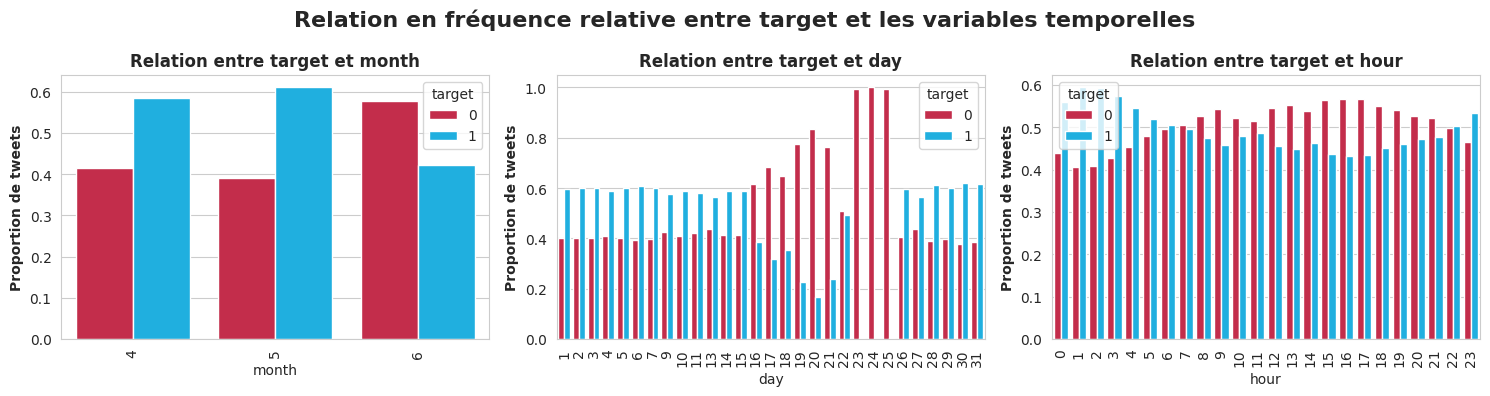

In [26]:
# Display the relation between target and the variables month, day, and hour
for title, method in zip(("absolue", "relative"), ("count", "proportion")):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False, tight_layout=True)
    fig.suptitle(
        f"Relation en fréquence {title} entre target et les variables temporelles",
        fontweight="bold",
        fontsize=16,
    )
    sns.set_style("whitegrid")
    for i, col in enumerate(["month", "day", "hour"]):
        sns.barplot(
            df.groupby(col)["target"]
            .value_counts(normalize=True if title == "relative" else False)
            .reset_index(),
            x=col,
            y=method,
            hue="target",
            palette=palette,
            ax=ax[i],
        )
        ax[i].set_title(f"Relation entre target et {col}", fontweight="bold")
        ax[i].set_xlabel(col)
        ax[i].set_ylabel(
            "Proportion de tweets" if title == "relative" else "Nombre de tweets",
            fontweight="bold",
        )
        ax[i].set_xticks(ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    plt.show()

On peut noter que **certaines journées ne sont pas présentes (le 8 et le 12)**.<br>
Pour une raison inconnue, les jours 23, 24 et 25 sont uniquement **négatifs**.<br>
La répartition des tweets n'est pas uniforme **sur les mois**, avec une concentration beaucoup plus forte en mai (+ de positif) et en juin (+ de négatif) qu'en avril avec la faible relation linéaire négative identifiée dans la matrice de corrélation.<br>

On identifie deux relations non linéaires à:
- **l'échelle journalière**: Les tweets négatifs sont plus fréquents en milieu de mois et les tweets positifs en début et fin de mois.
- **l'échelle horaire**: on a un cycle en forme d'ADN, la nuit étant plus propice aux tweets positifs, la tendance s'inversant durant la matinée avant de voir l'après-midi plus propice aux tweets négatifs


Dans l'absolu, **seule la variable horaire semble avoir un lien avec la target**. Les autres variables sont  biaisées par leur fréquence relative déséquilibrée.

In [27]:
# Sélection de données restreintes
df = df.filter(["target", "text", "hour"])

# Assign the len of the preprocessed dataframe
n_rows = len(df)

Commençons par avoir un aperçu d'une sélection de tweets aléatoires:

In [28]:
with pd.option_context("display.max_colwidth", 150):
    display(df[["text", "target"]].sample(25))

,text,target
1390831,@blackdogcoffee Charles Town - time to gamble,1
310392,bored and having to go and cook can't be bothered,0
86383,is finding it difficult.. trying to be platonic,0
1504896,@Yuyucow Que es VN? Suena Kinky,1
1088488,@AlexanderBor awww.... i have my exams on tuesday,1
611302,@Veglio Oh dear Happy landings!,0
1187462,ahh thats better mm lovin' the bbq ;),1
377221,@judez_xo is you okies judy ?,0
718618,i don't like headaches,0
31115,GUESS I'M NOT GOING TO BED TONIGHT lol...,0


# **Séparation des données**

In [29]:
# Define if working with a sample
sampling = True
proportion = 0.01

# Split the data with sampling or not
if sampling:
    if len(df) != n_rows:
        print("Dataframe has already been sampled")
    else:
        print(f"Sampling the data with {proportion} fraction")
        df = df.sample(frac=proportion, random_state=SEED)

# Define X and y
X = df[["text"]]
y = df["target"]

# Split the data with a 0.2 test size
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Display shape of splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Sampling the data with 0.01 fraction
X_train shape: (12772, 1)
X_test shape: (3194, 1)
y_train shape: (12772,)
y_test shape: (3194,)


# **Modélisation**

In [30]:
# Load a spacy model of your choice
spacy_model = "en_core_web_sm"
disable = ["ner"]

# Check if gpu is available to use it with spacy
if cuda:
    spacy.prefer_gpu()

# Load the model without the ner component and download it if needed
try:
    nlp = spacy.load(spacy_model, disable=disable)
except OSError as e:
    print(e)
    print(f"Downloading the {spacy_model} model...")
    spacy.cli.download(spacy_model)
    # Add sleep time
    time.sleep(5)
    # Finally load the model
    print("Loading the model...")
    nlp = spacy.load(spacy_model, disable=disable)
finally:
    print(f"{spacy_model.upper()} model loaded successfully :)")
    print(f"Model components: {nlp.pipe_names}")


[E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.5 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Loading the model...
EN_CORE_WEB_SM model loaded successfully :)
Model components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [31]:
# Add the language detector variable name
name = "language_detector"

# Register the language detector as a component and add it as a component
if name not in Language.factories.keys():

    @Language.factory(name)
    def create_language_detector(nlp, name):
        return LanguageDetector()


# Add the language detection component to the pipeline if it's not already added
if name not in nlp.pipe_names:
    nlp.add_pipe(name, last=True)

print("Language detection component added to the pipeline as {}.".format(name))

Language detection component added to the pipeline as language_detector.


In [32]:
# Add the emoji detector variable name
name = "emoji_detector"

# Register the emoji detector as a component and add it as a component
if name not in Language.factories.keys():

    @Language.factory(name)
    def create_emoji_detector(nlp, name):
        return Emoji(nlp)


# Add the language detection component to the pipeline if it's not already added
if name not in nlp.pipe_names:
    nlp.add_pipe(name, first=True)

print("Emoji detection component added to the pipeline as {}.".format(name))

Emoji detection component added to the pipeline as emoji_detector.


In [33]:
def spacy_preprocess(text, nlp=nlp, params=0):
    """
    Preprocess the text using spacy pipeline
    """
    # Process the text
    doc = nlp(text)
    #
    match params:
        case 0:
            tokens = [token for token in doc if token.is_aplha]
        case 1:
            tokens = [token.lemma_ for token in doc if token.is_alpha]
        case 2:
            tokens = [
                token.lemma_ for token in doc if token.is_alpha and not token.is_stop
            ]
        case 3:
            tokens = [
                token.lemma_ for token in doc if token.is_alpha or token._.is_emoji
            ]
        case _:
            return doc
    return tokens

In [34]:
text_with_emoji = "I loved my cats and dogs or 🐱 and 🐶"
spacy_preprocess(text_with_emoji, nlp=nlp, params=3)


['I', 'love', 'my', 'cat', 'and', 'dog', 'or', '🐱', 'and', '🐶']

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [38]:
with mlflow.start_run():
    # Select the preprocessor parameters
    preprocessor = partial(spacy_preprocess, params=3)
    # Fit and transform the tf-idf vectorizer on the text column
    tfidf = TfidfVectorizer(
        tokenizer=preprocessor,
        ngram_range=(1, 3),
        max_features=1000,
        strip_accents="unicode",
    )
    X_embed = tfidf.fit_transform(X_train["text"].str.lower())
    # Initialize the model
    model = LogisticRegression(max_iter=1000)
    # Add the input example
    input_logit = X_embed[0]
    input_tfidf = X_train["text"].str.lower().values[0]
    # Perform a cross-validation
    scores = cross_validate(model, X_embed, y_train, cv=5, scoring=["accuracy", "f1"])
    # Your training code here...
    model.fit(X_embed, y_train)
    y_pred = model.predict(tfidf.transform(X_test["text"].str.lower()))
    scores = pd.DataFrame(scores).mean()
    acc_score = accuracy_score(y_test, y_pred)
    for metric in scores.keys():
        mlflow.log_metric(f"val_{metric}", scores[metric])
    mlflow.log_metric("test_accuracy", acc_score)
    mlflow.log_param("Dimension", X_embed.shape[1])
    mlflow.log_param("Tf-Idf params", tfidf.get_params())
    mlflow.log_param("Logistic Regression params", model.get_params())
    mlflow.sklearn.log_model(model, "logistic_regression", input_example=input_logit)
    mlflow.sklearn.log_model(
        tfidf, "tfidf_vectorizer", input_example=input_tfidf, signature=False
    )

/home/hedredo/github_repo/dagshub_p7/.conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024/10/25 10:26:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/25 10:26:59 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": "free at last! getting off for the weekend.  no big plans, but i cant wait to relax."
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: Model does not have the "python_function" flavor
2024/10

In [40]:
# Initialize the model
model = MultinomialNB()

# Perform a cross-validation
scores = cross_validate(model, X_embed, y_train, cv=5, scoring=["accuracy", "f1"])

# Display the scores
pd.DataFrame(scores).mean()

fit_time         0.004180
score_time       0.002549
test_accuracy    0.721813
test_f1          0.717116
dtype: float64

In [41]:
tweet_tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True,
)

In [42]:
# Fit and transform the tf-idf vectorizer on the text column
tfidf = TfidfVectorizer(
    tokenizer=tweet_tokenizer.tokenize,
    ngram_range=(1, 3),
    max_features=1000,
    strip_accents="unicode",
)
X_embed = tfidf.fit_transform(X_train["text"].str.lower())

/home/hedredo/github_repo/dagshub_p7/.conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
# Initialize the model
model = MultinomialNB()

# Perform a cross-validation
scores = cross_validate(model, X_embed, y_train, cv=5, scoring=["accuracy", "f1"])

# Display the scores
pd.DataFrame(scores).mean()

fit_time         0.002604
score_time       0.002531
test_accuracy    0.722909
test_f1          0.718497
dtype: float64

In [44]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Perform a cross-validation
scores = cross_validate(model, X_embed, y_train, cv=5, scoring=["accuracy", "f1"])

# Display the scores
pd.DataFrame(scores).mean()

fit_time         0.024150
score_time       0.002697
test_accuracy    0.735358
test_f1          0.735984
dtype: float64

In [46]:
import textstat

textstat.set_lang("en")

In [47]:
# Définir une fonction combinée pour les transformations
def combined_transformations(text):
    return {
        "readability_score": textstat.text_standard(text, float_output=True),
        "reading_time": textstat.reading_time(text, ms_per_char=14.69),
        "syllables_count": textstat.syllable_count(text),
        "words_count": textstat.lexicon_count(text, removepunct=True),
        "sentences_count": textstat.sentence_count(text),
        "chars_count": textstat.char_count(text, ignore_spaces=True),
        "letters_count": textstat.letter_count(text, ignore_spaces=True),
    }


# Appliquer la fonction combinée avec tqdm
transformed_data = X_train["text"].progress_apply(combined_transformations)

# Transforme le résultat en DataFrame
transformed_data = pd.DataFrame(transformed_data.tolist())

100%|██████████| 12772/12772 [00:02<00:00, 6166.65it/s]


In [48]:
transformed_data.head()

,readability_score,reading_time,syllables_count,words_count,sentences_count,chars_count,letters_count
0,1.0,0.97,20,17,3,66,62
1,4.0,1.34,23,16,2,91,75
2,6.0,0.79,15,11,2,54,52
3,1.0,0.35,5,3,1,24,23
4,4.0,0.53,13,10,1,36,36


In [49]:
transformed_data["average_word_length"] = (
    transformed_data["chars_count"].div(transformed_data["words_count"]).round(2)
)
transformed_data["average_sentence_length"] = (
    transformed_data["words_count"].div(transformed_data["sentences_count"]).round(2)
)
transformed_data["average_syllables_per_word"] = (
    transformed_data["syllables_count"].div(transformed_data["words_count"]).round(2)
)

Comme nous avons énormément de données à analyser, nous allons tester la performance du modèle en utilisant uniquement les features à notre disposition.<br>
Le modèle sera plus rapide s'il reçoit en entrée une sparse matrix plutôt qu'une dense matrix.<br>

# **Options de standardisation des textes**

Voici une liste de 10 moyens de standardiser votre corpus de tweets pour l'analyse de sentiments :

1. **Conversion en minuscules** : Transformer tous les caractères en minuscules pour uniformiser le texte.
2. **Suppression de la ponctuation** : Enlever tous les signes de ponctuation qui peuvent ne pas être pertinents pour l'analyse.
3. **Élimination des mots vides (stop words)** : Supprimer les mots courants qui n'ajoutent pas de valeur sémantique significative (comme "le", "la", "de", etc.).
4. **Stemming** : Réduire les mots à leur racine pour traiter les variations morphologiques (par exemple, "aimant", "aimer", "aimé" deviennent "aim").
5. **Lemmatisation** : Transformer les mots en leur forme de base ou canonique (par exemple, "étudiants" devient "étudiant").
6. **Suppression des nombres** : Enlever les chiffres qui peuvent ne pas être utiles pour l'analyse de sentiments.
7. **Traitement des URL** : Remplacer les liens par un token spécifique comme `<URL>` pour uniformiser le texte.
8. **Gestion des mentions** : Remplacer les @utilisateur par un token comme `<MENTION>` pour éviter les informations spécifiques inutiles.
9. **Traitement des hashtags** : Extraire le mot-clé du hashtag (par exemple, "#bonheur" devient "bonheur") pour conserver le sens.
10. **Gestion des emojis et émoticônes** : Remplacer les emojis par leur signification textuelle ou les supprimer si nécessaire (par exemple, "😊" devient "heureux").

Ces standardisations peuvent vous aider à améliorer la qualité de vos données et potentiellement les performances de vos modèles de classification en réduisant le bruit et en uniformisant le corpus.

**EDA**

* Longueur str
* Nombre de tokens
* Longueur moyenne / min / max / std token
* Compte le nombre d'erreurs unidecode
* Compte le nombre de tags
* Comptre le nombre de hashtags
* Compte le nombre de mentions
* Compte le nombre d'emoji
* Compte le nombre d'URL
* Regarder textastic/chatgpt/ pour l'argot et les abréviations
* Etc...

In [24]:
def preprocess_text(
    text: str,
    lowercase: bool = True,
    root: str = "raw",
    rm_punct: bool = True,
    rm_stopwords: bool = True,
    rm_numbers: bool = True,
    rm_url: bool = True,
    rm_mention: bool = True,
    rm_hashtag: bool = True,
    rm_emoji: bool = True,
):
    # Root error management
    match root:
        case "lemma" | "stem" | "raw":
            pass
        case _:
            raise ValueError("root must be 'lemma', 'stem' or 'raw'")

    # TO WRITE

    # Return the preprocessed text
    return text

In [ ]:
# Define a pattern to match urls in the description column
url = r"www\.\S+"  # correct pattern for urls
email = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"
hashtag = r"#\S+"
mentions = r"@\S+"
emoji = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+"